In [31]:
# load module
%matplotlib notebook
# import instaseis
import numpy as np
import matplotlib.pyplot as plt
import h5py

# download from https://pypi.org/project/seissolxdmf/
import seissolxdmf

import pyproj
import scipy.io as sio
import matplotlib.tri as tri
# from mpl_toolkits.basemap import Basemap
# from scipy import spatial
from netCDF4 import Dataset

print('load successfully!')

load successfully!


In [32]:
# import instaseis
from obspy import read
from obspy.taup import TauPyModel as taup
from obspy.taup.taup_geo import calc_dist_azi as calc_dist_azi
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import correlate
from obspy.signal.cross_correlation import xcorr_max


# plot regional seismic network and compare seismograph
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
from obspy.signal.rotate import rotate2zne
from obspy.core.stream import Stream
from obspy import read,read_inventory
# from obspy.signal.cross_correlation import xcorr
from obspy.signal.rotate import rotate_ne_rt
from obspy import Trace, Stream

In [41]:
cl_iris  = Client("IRIS")
# nw = ['AK','AK','AK','NP','NP']       # network
# sta= ['CHN','S15K','S19K','8051','8035']      # station
# ch = ['BN*','HN*','HN*','HN*','HN*']        # channel

nw = ['AK','AK','AK']       # network
sta= ['CHN','S15K','S19K']      # station
ch = ['BN*','HN*','HN*']        # channel

# nw = ['AV','AV','AK','AK','AK']       # network
# sta= ['VNKR','DOL','S15K','CHN','R16K']  # station
# ch = ['EHZ','BHZ','HNZ','BHZ','BHZ']      # channel
# Event catalog

cat = cl_iris.get_events(minmagnitude=8.1,maxmagnitude=8.3, starttime=UTCDateTime(2021,7,28),endtime=UTCDateTime(2021,7,30)) # Y
event = cat[0]
print(cat)  

start = event.origins[0].time
end = start + 200

waveform = Stream()

for num in np.arange(0,3):
# for num in np.arange(1,2):
    if (num == 0):
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  = inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    else:
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  += inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    
    st.remove_response(inventory=inv,output='vel') 
    st.detrend('simple')
    waveform += st
#     print("Station %f: DONE " %(str(sta[num])))
print(waveform)

1 Event(s) in Catalog:
2021-07-29T06:15:49.188000Z | +55.364, -157.888 | 8.2  Mww


ValueError: The current client does not have a station service.

In [25]:
sta= ['CHN','S15K']
ch = ['BNE','BNN','BNZ']
# ista = ['03','13']
ista = ['14','16']

modelname  = 'alkR057-TP60'
# icore = ['16','29'] # tp20
icore = ['64','12']
modelname = 'alkR057-2hz'
foldername = 'result2hz/'
# modelname  = 'alkR057-TP64'
# icore = ['47','30']


waveform_syn = Stream()
for num in range(len(sta)):
    if num < 10:
        filename = foldername +modelname + '-receiver-000%s-000%s.dat'%(ista[num],icore[num])
#         if num == 0:
        t, vx, vy, vz = np.loadtxt(filename, comments='#', skiprows=2,usecols=(0,7,8,9),unpack=True)
        st = Stream([Trace(vx),Trace(vy),Trace(vz)])    
        for tr_num in range(3):
            st[tr_num].stats['sampling_rate'] = 200
            st[tr_num].stats['network'] = 'SeisSol'
            st[tr_num].stats['station'] = sta[num] 
            st[tr_num].stats['channel'] = ch[tr_num]
        waveform_syn += st


<IPython.core.display.Javascript object>


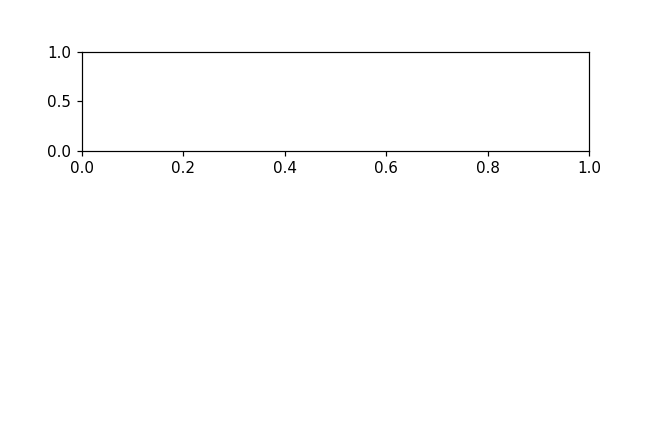

IndexError: list index out of range

In [26]:
f1 = 0.05
f2 = 0.50

waveform_syn1 = waveform_syn.copy()
waveform_syn1.differentiate()
waveform_syn1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)

waveform1 = waveform.copy()
waveform1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)
   
num = 1 # Station s15k

plt.figure(figsize=(6, 4))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='HNE')[0].times(),waveform1.select(station=sta[num],channel='HNE')[0].data,'k',label='%s - HNE' %(sta[num]))
ax1.plot(waveform_syn1.select(channel='BNE')[0].times(),waveform_syn1.select(channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()
ax1.set_xticks([])

ax2 = plt.subplot(312)
ax2.plot(waveform1.select(station=sta[num],channel='HNN')[0].times(),waveform1.select(station=sta[num],channel='HNN')[0].data,'k',label='%s - HNN' %(sta[num]))
ax2.plot(waveform_syn1.select(channel='BNN')[0].times(),waveform_syn1.select(channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()
ax2.set_xticks([])

ax3 = plt.subplot(313)
ax3.plot(waveform1.select(station=sta[num],channel='HNZ')[0].times(),waveform1.select(station=sta[num],channel='HNZ')[0].data,'k',label='%s - HNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(channel='BNZ')[0].times(),waveform_syn1.select(channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()
ax3.set_xticks([0,50,100,150])

ax3.set_xlabel('Time [s]')



# ax3.set_xlabel('Time [s]')

plt.show()
outname = 'seismo_'+modelname+'_'+ sta[num] +'.png'
plt.savefig(outname,dpi=200,format='png',transparent=False)

In [ ]:
      
num = 0 # Station CHN

plt.figure(figsize=(6, 4))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='BNE')[0].times(),waveform1.select(station=sta[num],channel='BNE')[0].data,'k',label='%s - BNE' %(sta[num]))
ax1.plot(waveform_syn1.select(channel='BNE')[0].times(),waveform_syn1.select(channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()
ax1.set_xticks([])

ax2 = plt.subplot(312)
ax2.plot(waveform1.select(station=sta[num],channel='BNN')[0].times(),waveform1.select(station=sta[num],channel='BNN')[0].data,'k',label='%s - BNN' %(sta[num]))
ax2.plot(waveform_syn1.select(channel='BNN')[0].times(),waveform_syn1.select(channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()
ax2.set_xticks([])

ax3 = plt.subplot(313)
ax3.plot(waveform1.select(station=sta[num],channel='BNZ')[0].times(),waveform1.select(station=sta[num],channel='BNZ')[0].data,'k',label='%s - BNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(channel='BNZ')[0].times(),waveform_syn1.select(channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()
ax3.set_xticks([0,50,100,150])

ax3.set_xlabel('Time [s]')

plt.show()

outname = 'seismo_'+modelname+'_'+ sta[num] +'.png'
plt.savefig(outname,dpi=200,format='png',transparent=False)

In [18]:
# cut data

## folder and model 
modelname = 'tp20m'
foldername = '/import/freenas-m-05-seissol/dli/Alaska2021/result4/'

## initialize seissolxdmf
fn = foldername + modelname +'-fault.xdmf'
# initiate class
sx = seissolxdmf.seissolxdmf(fn)

In [37]:
ndt = sx.ReadNdt()-1
    # ndt=90
xyz = sx.ReadGeometry()
connect = sx.ReadConnect()
print(connect)

[[  2325     62      0]
 [     1      2     21]
 [    31      2      1]
 ...
 [303002 303114 303047]
 [303114 303002 303003]
 [303049 303115 303116]]


In [33]:
asl1 = np.zeros((1,604041))
td1 = asl1
pn1 = asl1

asl= sx.ReadData('ASl',ndt)
td = sx.ReadData('Td0',ndt)
pn = sx.ReadData('Pn0',ndt)
asl1[0,:] = asl
td1[0,:] = td
pn1[0,:] = pn

print(asl1.shape)

(1, 604041)


In [40]:
## save data
hf = h5py.File('tp20m-fault.h5', 'w')
hf.create_dataset('xyz', xyz.shape,data=xyz)
hf.create_dataset('connect', connect.shape, data=connect)
hf.create_dataset('asl', asl1.shape,data=asl1)
hf.create_dataset('td', td1.shape,data=td1)
hf.create_dataset('pn', pn1.shape,data=pn1)

<HDF5 dataset "pn": shape (1, 604041), type "<f8">

In [41]:
hf.keys()

<KeysViewHDF5 ['asl', 'connect', 'pn', 'td', 'xyz']>

In [36]:
print(asl1.shape,xyz.shape,connect.shape)

(1, 604041) (303117, 3) (604041, 3)


In [15]:
fsurf = foldername + modelname +'-surface.xdmf'
sxsurf = seissolxdmf.seissolxdmf(fsurf)
ndt = sxsurf.ReadNdt()-1
    # ndt=90
xyz = sxsurf.ReadGeometry()
connect = sxsurf.ReadConnect()

slpz = sxsurf.ReadData('W',ndt)
slpy = sxsurf.ReadData('V',ndt)
slpx = sxsurf.ReadData('U',ndt)

hf = h5py.File('tp20m-surface.h5', 'w')
hf.create_dataset('xyz', data=xyz)
hf.create_dataset('connect', data=connect)
hf.create_dataset('U', data=slpx)
hf.create_dataset('V', data=slpy)
hf.create_dataset('W', data=slpz)

<HDF5 dataset "W": shape (112784,), type "<f8">